# Facility Location and Path Optimization as ParaSDM
### Tabular Q-Learning

Import Modules

In [21]:
# import all the packages
from numpy import *;
import numpy as np;
import matplotlib.pyplot as plt; plt.rcParams.update(plt.rcParamsDefault);
import itertools;
import math;
import scipy.io as scio;
import copy;
import time;
import pickle;
from scipy.optimize import minimize;
from matplotlib import patches;
import warnings;
from scipy.spatial.distance import cdist;
from scipy.optimize import LinearConstraint;
from scipy.special import *;

Function to generate FLPO datasets

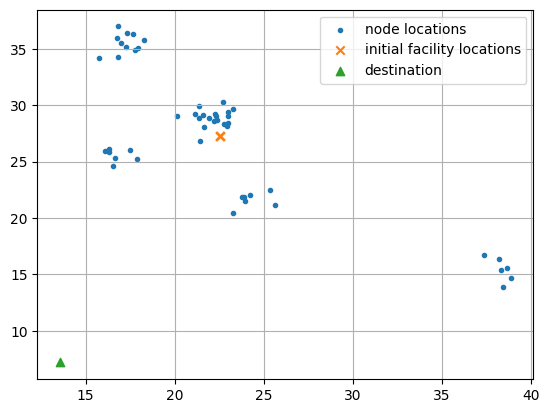

In [462]:
def generate_dataset(n, cov, k,scale=30,seed=0):
    # Generate random means for each cluster
    np.random.seed(seed)
    means = np.random.rand(k, 2)*scale

    # Generate random points in k clusters
    nodes = np.zeros((n, 2))
    for i in range(n):
        cluster = np.random.randint(0, k)  # Choose a random cluster
        nodes[i] = np.random.multivariate_normal(means[cluster], cov)
    Y_s = np.tile(np.sum(nodes, axis=0), (k,1))/n
    dest = np.random.rand(1,2)*scale
    return nodes,Y_s,dest

# Example usage
n = 50  # Total number of points
var = 5e-1 # variance of each cluster
cov = np.eye(2) * var # Covariance matrix
k = 5  # Total number of clusters
nodes, Y_s, dest = generate_dataset(n, cov, k, scale=40,seed = 0)
plt.scatter(nodes[:,0],nodes[:,1],marker='.')
plt.scatter(Y_s[:,0],Y_s[:,1],marker='x')
plt.scatter(dest[:,0],dest[:,1],marker='^')
plt.grid()
plt.legend(['node locations','initial facility locations','destination'])
plt.show()
smallCellNetdata = {'numNodes':n, 'numFacilities':k, 'nodeLocations':nodes, 'facilityLocations':Y_s, 'destinationLocation':dest}
filename = 'smallCellNetData.pkl';

# with open(filename, 'wb') as file:
#     pickle.dump(smallCellNetdata, file)

Create numerous datasets

In [463]:
N_scenarios = 10 # number of different scenarios to benchmark on

n = 50 # Total number of points
var = 5e-4 # variance of each cluster
cov = np.eye(2) * var # Covariance matrix
Scenarios = []
M_values = [5,] # Number of facilities
for i in range(N_scenarios):
    for M in M_values:
        nodes, Y_s, dest = generate_dataset(n, cov, M, scale=1,seed = 10+i)
        smallCellNetdata = {'numNodes':n, 'numFacilities':M, 'nodeLocations':nodes, 'facilityLocations':Y_s, 'destinationLocation':dest}
        filename = 'smallCellNetData_'+str(i).zfill(2)+'_'+str(M).zfill(2)+'.pkl';
        with open(filename, 'wb') as file:
            pickle.dump(smallCellNetdata, file)
        Scenarios.append(filename)

print(Scenarios)

['smallCellNetData_00_05.pkl', 'smallCellNetData_01_05.pkl', 'smallCellNetData_02_05.pkl', 'smallCellNetData_03_05.pkl', 'smallCellNetData_04_05.pkl', 'smallCellNetData_05_05.pkl', 'smallCellNetData_06_05.pkl', 'smallCellNetData_07_05.pkl', 'smallCellNetData_08_05.pkl', 'smallCellNetData_09_05.pkl']


### Create Environment

In [464]:
#define the model here as a class
class FLPOasParaSDM():

    #firstly define the data member for the model
    n: int; #number of nodes,
    f: int; #number of cell towers;
    nodeLocations: np.ndarray; #nx2 matrix including the node coordinates (fixed)
    facilityLocations: np.ndarray; #fx2 matrix storing the cell-tower locations (changable)
    destinationLocation: np.ndarray; #1x2 matrix storing the destination location (fixed)#
    st:int; # id for state of the system
    reward2cost:int; # reward to cost conversion factor
    selfHop:bool; # flag to indicate if self-hopping is allowed or not

    #define a probability transition matrix for the model.... (s,a) -> nextState
    P:np.ndarray;
    #define a cost function matrix for the transition (s,a) -> nextState
    C:np.ndarray;
    #define a gradient matrix wrt for each (s, a, s') for each parameters
    G:np.ndarray;
    #define a an action mask sxa dimensional matrix
    action_mask:np.ndarray;


    #define the constructor
    def __init__(self, datafile:str, init_state=0, selfHop=0, init_distribution='unifNodes'):
        '''
        function initializes the small cell network model.
        datafile: datafile containing the dataset
        init_state: initial model state (default set to state 0)
        init_distribution: initial state distribution of the model (default set of uniform distribution over the nodal states)
        '''

        #now load the mat file from the path and get the locations
        with open(datafile, 'rb') as file:
            data = pickle.load(file)
        
        # initialize model parameters
        self.n = data['numNodes'] # number of nodes
        self.f = data['numFacilities'] # number of facilities
        self.nodeLocations = data['nodeLocations']; # node locations
        self.destinationLocation = data['destinationLocation']; # destination location
        self.st = init_state; # initial state
        self.selfHop = selfHop; # whether self hopping is allowed or not

        # the state and the action space for the model
        self.state_space = [(s,) for s in np.linspace(0, self.n+self.f*self.f, self.n+self.f*self.f+1, dtype = int)];
        self.state_space_shape = len(self.state_space);
        self.action_space = [(a,) for a in np.linspace(0, self.f*self.f, self.f*self.f+1, dtype = int)];
        self.act_space_shape = len(self.action_space);

        self.init_params(); #initialize model parameters, compute cost and gradient matrix
        self.init_state_distribution(init_distribution); # initialize model state distribution
        self.init_probab_matrix(); # initialze model state-transition probability
        self.init_action_mask(); # initialize the action-mask

    # function to compute initial state distribution
    def init_state_distribution(self, distribution_type:str):
        '''
        function computes a distribution for initialization of states
        distribution_type : string to indicate whether the distribution is uniform over all the states or only over the nodes
        '''
        rho = np.zeros(self.state_space_shape); # initialize

        if distribution_type == 'unifNodes':
            # uniform distribution over the nodal states
            rho[1+self.f**2:] = np.ones(self.n);
        elif distribution_type == 'unifStates':
            # uniform distribution over all the states
            rho = np.ones(self.state_space_shape)

        # normalize
        self.rho = rho/np.sum(rho)

        pass;
    
    #define a function to initialize the probability transition
    def init_probab_matrix(self): ##Exclusive to the matricized version of the algorithm
        '''
        function initializes the probability transition matrix for matriced algorithms
        probability transition matrix is sxaxs dimensional tensor (3d tensor)
        '''
        #start with an initial zeros matrix
        #now for any state action pair, we must assign the corresponding probability of going to the next state
        #w.p 0.9 goto the state mentioned in the action
        self.P = np.tile(np.expand_dims(np.eye(self.act_space_shape,self.state_space_shape), axis=0), (self.state_space_shape,1,1));
        #and the destination gets an additional 0.1 probability....bcoz we goto destinaition with probability 0.1
        # self.P[:,:,0] += 0.1;
        pass;
    
    #define a function to update cost matrix..after change of parameters
    def compute_cost_matrix(self):
        # initialize the cost matrix at very high cost for all state-action pairs
        C = 0*np.ones(shape = (self.state_space_shape, self.state_space_shape))
        # compute lower dimensional cost matrix of the original FLPO problem as intermediate cost
        C_interm = np.sum(self.X**2, axis=1, keepdims=True) + np.sum(self.X**2, axis=1, keepdims=True).T - 2*(self.X @ self.X.T);

        # pick sections of intermediate cost
        Cf2f = C_interm[1:self.f+1, 1:self.f+1]; # facilities to facilities
        Cf2d = C_interm[1:self.f+1, 0]; # facilities to destination
        Cn2f = C_interm[self.f+1:, 1:self.f+1]; # nodes to facilities
        Cn2d = C_interm[self.f+1:, 0] # nodes to destination

        # now fill the higher dimensional cost matrix with the values of intermediate costs for allowable transitions
        for p in range(self.f+2):
            if p == 0:
                # from destination
                C[0,0] = 0; # to destination only
            elif p == 1:
                # from FLPO stage 1 facilities
                C[1:self.f+1, 0] = Cf2d; # to destination 
                C[1:self.f+1, self.f+1:1+2*self.f] = Cf2f; # to FLPO stage 2 facilities
            elif p < self.f and p > 1:
                # from FLPO stage p facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination
                C[1+(p-1)*self.f:1+p*self.f, 1+p*self.f:1+(p+1)*self.f] = Cf2f # to FLPO stage p+1 facilities
            elif p == self.f:
                # from FLPO final stage facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination only
            elif p == self.f+1:
                # from FLPO nodes
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 1:1+self.f] = Cn2f # to facilities
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 0] = Cn2d # to destination

        # expand the cost matrix to define it for each action as well
        self.C = np.tile(np.expand_dims(C, axis=1), (1, self.act_space_shape, 1));
        pass;

    #define a function to iniitalize the gradient wrt parameters for each sxaxs combintation
    def compute_grad_matrix(self):
        '''
        initialize the gradient w.r.t parameter tensor which is a state x action x nextState x parameter dimensional tensor..
        '''
        # initialize lower dimensional gradient matrix
        Gtemp = np.zeros(shape = (self.f+self.n+1, self.f+self.n+1, len(self.parameters())));
        # initialize higher dimensional gradient matrix
        G = np.zeros(shape = (self.state_space_shape, self.state_space_shape, len(self.parameters())));

        # fill up the values for the lower dimensional gradient matrix
        for p in range(self.f):
            Gtemp[p+1,:,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[p+1,:,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
            Gtemp[:,p+1,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[:,p+1,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
        Gd2f = Gtemp[0,1:self.f+1,:]; # destination to facilities 
        Gf2f = Gtemp[1:self.f+1,1:self.f+1,:]; # facilities to facilities
        Gf2n = Gtemp[1:self.f+1,self.f+1:,:]; # facilities to nodes
        Gf2d = Gtemp[1:self.f+1,0,:]; # facilities to destination
        Gn2f = Gtemp[self.f+1:,1:self.f+1,:]; # nodes to facilities

        G[0, 1:1+self.f*self.f, :] = np.tile(Gd2f, (self.f,1)); # destination 2 facilities
        G[1:1+self.f*self.f, 0, :] = np.tile(Gf2d, (self.f,1)); # facilities 2 destination
        G[1:1+self.f*self.f, 1:1+self.f*self.f,:] = np.tile(Gf2f, (self.f,self.f,1)); # facilities 2 facilities
        G[1:1+self.f*self.f, 1+self.f*self.f:,:] = np.tile(Gf2n, (self.f,1,1)); # facilities 2 nodes
        G[1+self.f*self.f:, 1:1+self.f*self.f,:] = np.tile(Gn2f, (1,self.f,1)); # nodes 2 facilities

        #now populate the required elements of the matrix
        self.G = np.tile(np.expand_dims(G, axis=1), (1, self.act_space_shape, 1, 1));
        pass;
    
    #define a function to initialize the parameters for the model
    def init_params(self):
        ''' 
        function initializes model parameters, computes the state-cost transition and its gradient with respect to parameters
        '''
        #initialize the model parametrs to all zeros
        self.facilityLocations = np.zeros(shape = (self.f, 2));
        self.X = np.vstack([self.destinationLocation, self.facilityLocations, self.nodeLocations]);
        
        self.compute_cost_matrix();
        self.compute_grad_matrix();
        pass;
    
    #define a function to get the parameters for the model
    def parameters(self) -> np.ndarray:

        '''
        function returns a list of parameters for the system.
        '''

        #return the cell locations as the parameters list. each coordinate is a scalar parameter..
        return self.facilityLocations.reshape(-1);
    
    #define a function to update the parameters to a new value
    def update_params(self, params: np.ndarray):
        '''
        function to update the list of paramaters for the model to a new set of parameters
        params: updated list f parameters of the same length and shape of elements as in self.parameters()
        return :
        None
        '''

        #firstly check if the number of parameters in the list match
        assert(params.shape == self.parameters().shape);

        #now go over each parameter in the list and update the corresponding model parameter
        # for i in range(len(params)):
        #     #assign the correspondin parameter after checking the dimension
        #     # in this case of small cell network every parameter element is a coordinate in the facilityLocations matrix.
        #     # assert(params[i].shape == 1);
        #     self.facilityLocations[int(i/2), i%2] = params[i];
        
        self.facilityLocations = params.reshape(-1,2);

        #before updating the cost and gradient tensors...update the self.X vector with the updated parameters.
        self.X[1:self.f+1,:] = self.facilityLocations;

        #once parameters are updated...update the cost and gradient tensors for the model..
        self.compute_cost_matrix();
        self.compute_grad_matrix();

        pass;
    
    #define a function to set the system state
    def setState(self, state):
        #just set the state
        assert((state <= self.n + self.f*self.f) & (state>=0));
        self.st = state;
        pass;
    
    def state(self):
        return (self.st,);
    
    def get_actions(self, st):
        '''
        this function gives the set of all possible actions at a given state
        st: given state index lying in {0, 1, 2, . . . , 1+n+f^2}
        return:
        action_list: list of actions available for the present state of the system
        '''
        # check if the state st is a valid state
        assert((st <= self.n + self.f*self.f) & (st>=0));

        actions = [(a,) for a in np.where(self.action_mask[st] == 1)[0]]

        return actions
    
    #define a functino to define the action mask for the model....for matricized implementation
    def init_action_mask(self):
        '''
        Function to indicate allowable actions at every state
        '''
        self.action_mask = np.zeros(shape = (self.state_space_shape, self.act_space_shape));

        # allowable actions from destinations
        self.action_mask[0,0] = 1 # only destination is possible
        # allowable actions from nodes
        self.action_mask[self.f*self.f+1:, 0:self.f+1] = np.ones((self.n, 1+self.f)) # only destination and stage 1 facility locations are possible
        # allowable actions from stage p to stage (p+1) facilities
        for p in range(1,self.f):
            #only stage p to stage p+1 allowed (no self hopping) for p < self.f
            self.action_mask[(p-1)*self.f+1:p*self.f+1, p*self.f+1:(p+1)*self.f+1] = np.ones((self.f,self.f)) - np.eye(self.f)*(1-self.selfHop)
        self.action_mask[1:self.f*self.f+1,0] = 1 # destination allowed from all facilities in all stages

        pass;




Complementary functions

In [465]:
def getRoutes(model:FLPOasParaSDM, fp:np.ndarray):
    routes = np.zeros((model.n,model.f+1))
    for p in range(model.f+1):
        if p == 0: # from nodes
            goto_array = list(np.argmax(fp[1+model.f*model.f:], axis=1));
            routes[:,p] = np.array(goto_array)
        else:
            # find facilities to go in stage 2
            goto_array_temp = list(np.argmax(fp[goto_array], axis=1));
            routes[:,p] = np.array(goto_array_temp)
            goto_array = goto_array_temp;
    return routes;

def plotRoutes(model:FLPOasParaSDM, fp:np.ndarray):
    # plot the nodepoints first
    plt.figure(figsize=(5,5));
    plt.scatter(model.nodeLocations[:, 0], model.nodeLocations[:, 1], color='green', label='User Nodes');
    plt.scatter(model.facilityLocations[:, 0], model.facilityLocations[:, 1], marker = '^', color='black', label='Cell Towers');
    plt.scatter(model.destinationLocation[:, 0], model.destinationLocation[:, 1], marker = '*', color='red', label='Dest.');
    plt.xlabel(r'X');
    plt.ylabel(r'Y');
    plt.legend();
    labels = list(range(1+model.f+model.n));

    # for i in range(1+model.f+model.n):
    #     plt.annotate(labels[i], (model.X[i,0], model.X[i,1]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=8)
    
    D = 0;
    options = ['-', '--', '-.', ':',]

    routes = getRoutes(model, fp);

    for n in range(model.n):
        st = n;
        id_st_X = st + model.f + 1;
        for k in range(model.f+1):
            nst = routes[n][k]
            if nst != 0:
                line_style = np.random.choice(options);
                color = np.random.rand(3);
                id_nst_X = int((nst-1)%model.f) + 1;
                # print(id_nst_X)
                plt.plot([model.X[id_st_X,0], model.X[id_nst_X, 0]],
                         [model.X[id_st_X,1], model.X[id_nst_X, 1]],
                         color=color,linewidth=1.5,linestyle=line_style);
                D = D + np.sum((model.X[id_st_X] - model.X[id_nst_X])**2);
                st = nst;
                id_st_X = id_nst_X;
            elif nst == 0:
                line_style = np.random.choice(options);
                color = np.random.rand(3);
                id_nst_X = 0
                plt.plot([model.X[id_st_X,0], model.X[id_nst_X, 0]],
                         [model.X[id_st_X,1], model.X[id_nst_X, 1]],
                         color=color,linewidth=1.5,linestyle=line_style)
                D = D + np.sum((model.X[id_st_X] - model.X[id_nst_X])**2);
                st = nst;
                id_st_X = id_nst_X;

    plt.gca().set_aspect('equal')
    plt.grid();
    plt.title(r'Infinite-Horizon Time Invariant Implementation');
    plt.show()



Primary testing of the environment 

In [466]:
filename = Scenarios[0]
parasdm = FLPOasParaSDM(filename, init_distribution='unifNodes'); # 'unifNodes', 'unifStates'
# print('number of nodes = ', parasdm.n);
# print('number of facilities = ', parasdm.f);
# print('state space = ' , parasdm.state_space);
# print('action space = ' , parasdm.action_space);
# print('state space shape = ', parasdm.state_space_shape);
# print('action space shape = ', parasdm.act_space_shape);
# print('initial distribution = ', parasdm.rho);

id_state = np.random.choice(a = np.arange(parasdm.state_space_shape), p = parasdm.rho)
parasdm.setState(*parasdm.state_space[id_state]);
parasdm.setState(59);
# print('current state = ' , parasdm.st);
acts = parasdm.get_actions(*parasdm.state());
print('actions possible at state ', parasdm.st, '=', acts);

act = parasdm.action_space[np.random.choice(a = np.arange(parasdm.act_space_shape))]
print('line 15', act)
nextState = np.random.choice(a=np.arange(parasdm.state_space_shape), p = parasdm.P[(*parasdm.state(), *act)])
print('next state at state-action pair (', parasdm.state(), act, ') is ', nextState)

actions possible at state  59 = [(0,), (1,), (2,), (3,), (4,), (5,)]
line 15 (21,)
next state at state-action pair ( (59,) (21,) ) is  21


### Implement Q Learning to obtain the optimal policies

In [467]:
def QLearningMEP(model:FLPOasParaSDM, initQValue:np.ndarray, initPolicy:np.ndarray, beta_init:float, beta_grow:float, gamma:float, max_iters:int, max_episodes:int, QDiffTol=1e-5):
    ''' 
    This function performs tabular Q-learning iterations to approximate the state-action value function, and obtain the corresponding optimal policy
    
    inputs:
    initValue: initial value of the state-action value function (dimension: state_space_shape x act_space_shape)
    initPolicy: initial value of the policy - uniform distribution (dimension: state_space_shape x act_space_shape)
    beta_init: initial annealing parameter. Default set to 0.001
    beta_grow: annealing parameter grow rate (geometric). Default = 1.1
    gamma: discounting factor in the expected cost of the SDM. Default = 0.95
    max_iters: maximum iterations for each episode. Default = 10000000
    max_episodes: maximum episodes. Default = 1
    QTol: tolerance for Q value convergence. Default=1e-5

    return:
    Qestim: Estimated state-action value function
    finalPol: Final policy obtained using the estimated state-action value function
    '''
    # check the dimensions of the initial policy and the state-action value function
    assert(initPolicy.shape == (model.state_space_shape, model.act_space_shape))
    assert(initQValue.shape == (model.state_space_shape, model.act_space_shape))

    # initialization
    Qestim = initQValue.copy() # initial state-action value function
    finalQValue = initQValue.copy() # previous episode state-action value function
    visits = np.zeros(shape = (model.state_space_shape, model.act_space_shape)) # matrix to count the number of visits for every state-action pair
    finalPol = initPolicy.copy() # matrix to compute the final policy from the final state-action value function
    action_mask = np.zeros(shape=(model.state_space_shape, model.act_space_shape)) # initialize action mask (for each state, 1: action allowed, 0: action not allowed)
    beta = beta_init # annealing parameter
    normQDiff = []

    # run the episodes
    for ep in range(max_episodes):
        # print('\n## Episode = ', ep, ' ##')
        # pick an initial state as per the initial state-distribution
        init_state = model.state_space[
            np.random.choice(a=np.arange(model.state_space_shape), p=model.rho)
        ]
        model.setState(*init_state)   
        # print(' initial state = ', init_state)
        
        # perform Q-learning iterations for each beta
        for t in range(max_iters):

            state = model.state() # current model state

            # sample an action according to the given policy at given beta
            act = model.action_space[
                np.random.choice(a=np.arange(model.act_space_shape), p=finalPol[state])
            ] # chosen action

            visits[(*state, *act)] += 1 # update visits matrix
            nu = 0.1/(visits[(*state, *act)]+1)**0 # stepsize parameter

            # choose a next state according to state-transition probability model for a given state-action pair
            newState = model.state_space[
                np.random.choice(a=np.arange(model.state_space_shape), p=model.P[(*state, *act)])
            ]

            # obtain the transition cost from the environment using the state-action cost transition matrix
            cost = model.C[(*state, *act, *newState)]

            # update the state-action value function as per the Q-learning iteration
            acts_newState = model.get_actions(*newState) # possible actions at the new state
            valFunOverNewActs = np.array(
                [-beta/gamma*Qestim[(*newState,*actNew)] for actNew in acts_newState]) # value function array for all the possible actions
            maxValFun = np.max(valFunOverNewActs) # maximum of value function over the possible actions at the new state
            valFunOverNewActs -= maxValFun # update all the value functions by subtracting the maximum (for exponential computation in the next step)
            expOverNewActs = np.exp(valFunOverNewActs) # compute expoential for all the actions at the new state
            sumExpOverNewActs = np.sum(expOverNewActs) # compute the sum of all the exponentials to compute the denominator
            logSumTerm = np.log(sumExpOverNewActs) + maxValFun # the logsum term
            Qestim[(*state, *act)] -= nu*( 
                -cost + Qestim[(*state, *act)] + gamma**2/beta*logSumTerm) # update the state-action value function

            # update the policy using the updated state-action value function using the gibbs distribution
            tempNum = -beta/gamma*Qestim[state]
            tempNum[model.action_mask[state]==0] = -np.inf            
            finalPol[state] = np.exp(
                tempNum-np.max(tempNum)
                )/np.sum(np.exp(tempNum-np.max(tempNum)), keepdims=True)
            # print('calculated policy at state ', state, '= ', finalPol[state])
            
            # stopping criterion
            if newState == (0,): # stop the iterations if reached the destination
                break;

        # stopping condition
        # normQDiff.append(np.max(np.abs(Qestim - finalQValue)))
        # finalQValue = Qestim
        # if normQDiff[-1]/np.max(np.abs(Qestim)) < QDiffTol:
        #     print(f'QDiffTol achieved, #episodes = {ep}, normQ[ep] = {normQDiff[-1]} < {QDiffTol}')
        #     break
        # elif ep == max_episodes-1:
        #     print(f'maximum episodes reached, normG[ep] = {normQDiff[-1]}')

        # increase the annealing parameter
        beta = beta*beta_grow    

    return Qestim, finalPol, normQDiff


Reference Q-Iteration Functions

In [468]:
# define the Q-Iteration routine 
def QIteration(model:FLPOasParaSDM, initQValue:np.ndarray, beta:float, gamma:float, max_iters=1000, tolQDiff = 1e-5):
    ''' 
    This function evaluates state-action value function based on equation (15) in Amber's paraSDM paper
    initQValue: initial state-action value function
    beta: annealing parameter
    gamma: discounting factor
    '''
    assert(initQValue.shape == (model.state_space_shape, model.act_space_shape))
    finalQValue = initQValue.copy()
    
    for i in range(max_iters):
        
        prevQValue = finalQValue.copy()
        tempQValue1 = finalQValue.copy()
        tempQValue1[model.action_mask == 0] = np.inf
        
        minQValue = np.min(tempQValue1, axis=1, keepdims=True)
        assert(minQValue.shape == (model.state_space_shape,1))

        expQValue = np.exp(-beta/gamma*(tempQValue1-minQValue))
        assert(expQValue.shape == (model.state_space_shape, model.act_space_shape))

        logSum = np.log(np.sum(expQValue, axis=1)) - beta/gamma*np.squeeze(minQValue)
        assert(logSum.shape == (model.state_space_shape,))

        finalQValue = model.action_mask*np.sum(model.P*(model.C - gamma**2/beta*logSum), axis=2)
        assert(finalQValue.shape == (model.state_space_shape, model.act_space_shape))

        normQ = np.max(np.abs(finalQValue)*model.action_mask)
        # print('normQ = ', normQ)
        normQDiff = np.max(np.abs(finalQValue-prevQValue)*model.action_mask)
        # if normQDiff/normQ < tolQDiff:
        #     print(f'tolQDiff achieved, iters={i}, normQDiff = {normQDiff} < {tolQDiff}')
        #     break
        # elif i == max_iters-1:
        #     print(f'maximum iterations reached, normQDiff = {normQDiff}')

    return finalQValue

# define the Q iteration routine using Mustafa's code (this is for redundant verification of my above QIteration() routine)
def QIteration1(model:FLPOasParaSDM, initValue:np.ndarray, gamma:float, beta:float, n_iters:int, allow_print = True, reward2cost:int=-1) -> list:
    '''
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the value function
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    reward2cost: factor to specify reward/cost model. Use 1 for cost model and -1 for reward model. Default = -1
    return:
    finalValue: result of hte value iteration on the model.
    finalPolicy: optimized policy after value iteration on the model.
    train_params: evolution of parameters of concern during training iterations
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(initValue.shape ==  (model.state_space_shape, model.act_space_shape));

    #now go ahead and carry out the iterations of value iteration
    finalValue = initValue.copy();
    # action_mask = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    # finalPolicy = np.zeros(shape=model.state_space_shape(), dtype=int);
    train_params = {};
    norm_diff = [];

    for iter in range(n_iters):

        prev_Val=finalValue.copy();

        #for each iteration...instead of the serialized approach....just get the probability transition tensor from the model and the cost tensor
        #also get the action mask tensor from the model for use in the policy determination
        #firstly get hold of the probability and cost tensors..and use that to compute the unsummed first term
        l = np.log(np.maximum(1e-8,model.P)); l[l == -np.inf]=0;
        term1 = model.P * (model.C + (gamma/beta)*l); #this is the first term without summation over next states
        term1 = np.sum(term1, axis=tuple(-1*np.arange(1,2))); #summation over the next states...

        #now go ahead and compute the second term
        #for term 2 ...first compute the inner summation over next states and actions of the exponent of Q function
        tv = finalValue.copy(); tv[model.action_mask == 0] = np.inf;
        # me = np.min(tv, axis = 1, keepdims = True);
        me = np.min(tv, axis = tuple(-1*np.arange(1,2)), keepdims=True);
        e = model.action_mask * (finalValue - me); #Something to athink atn....how can we offset better?
        trash = beta/gamma;
        term2 = model.action_mask * np.exp((-beta/gamma)*e);
        term2 = np.sum(term2, axis=tuple(-1*np.arange(1,2))); #summation over possible next actions
        term2 = np.log(term2) + (-beta/gamma)*np.squeeze(me, axis=1); #
        stateValueFunction = -gamma/beta * term2; # compute stateValue function iteratively on the way
        term2 = np.tensordot(model.P, term2, axes=1); #product with corresponding probability and summation over next states
        term2 = term2 * ((gamma**2) /beta); #coefficient multiplication..

        #now combine the terms...and mask out using the action mask..to get the updated Q function
        finalValue = model.action_mask * (term1 - term2);
        
        #repeat
        norm_diff.append(np.max(abs(finalValue - prev_Val)));
        norm = np.max(abs(finalValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\n');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < 1e-4):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm} < 1e-3, Hence stopping QIteration');
            break;
    
    #finally after the iterations get the converged policy from the Q-function fixed point obtained..
    tv1 = finalValue.copy(); tv1[model.action_mask == 0] = np.inf;
    expo = np.exp((-beta/gamma) * (finalValue - np.min(tv1, axis= tuple(-1*np.arange(1,2)), keepdims=True))*model.action_mask)*model.action_mask ;#exponent of the q-function to get the final policy...
    sumexpo = np.sum(expo, axis=tuple(-1*np.arange(1,2)), keepdims= True);
    finalPolicy = expo/sumexpo;
    finalSumValue = np.sum(model.rho*stateValueFunction); # return the cumulative cost
    
    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return ([finalValue, finalPolicy, train_params, finalSumValue]);

### Implement G-Learning to obtain optimal parameters

G Iteration Equation


Let $\alpha = \zeta_s$ or $\alpha = \eta_a$ be a common representation for both the state or action parameter variables

$
K^{t+1}_{\alpha}(x_t, u_t) = K^t_{\alpha}(x_t, u_t) + \nu_t(x_t,u_t) \left(-K^t_{\alpha}(x_t, u_t) + \frac{\partial c_{x_t x_{t+1}}}{\partial\alpha} + \gamma G^t_{\alpha}(x_{t+1})\right)
$

$
G^{t+1}_{\alpha}(x_t) = \sum_a\mu_{a|x_t} K^{t+1}_{\alpha}(x_t,a)
$

The updates $G^{t+1}_{\alpha}({\cdot})$ should converge to the unique fixed-point $G^{\beta^*}_{\alpha}({\cdot})$ of the map $T:G_{\alpha} \rightarrow G_{\alpha}$ as described below:

$\left[TK^{\beta^*}_{\alpha}\right](s',a') = \sum_{s''} p_{s's''}^{a'} \left[\frac{\partial c_{s's''}^{a'}}{\partial \alpha} + \gamma G^{\beta^*}_{\alpha}(s'')\right]$



In [483]:
def GLearningMEP(model:FLPOasParaSDM, policy:np.ndarray, gamma:float, max_iter=10000, max_episodes=1000, GDifftol=1e-5):
    ''' 
    This function approximates the gradient of value function with respect to states and action parameters using G-Learning iterations.
    The function creates a copy of the original environmental model with slightly different parameter values. Slighly different values of the parameters
    result into slightly different cost models which can be used to compute the gradients
    
    inputs:
    policy: optimal state-action policy
    deltaParamMean: perturbation parameter mean for dummy environment parameters
    deltaParamStd: perturbation parameter standard deviation for dummy environment parameters
    gamma: discounting factor
    maxEpisodes: maximum number of episodes for G-iteration. Default = 1000
    maxIter: maximum number of iterations per episode for G-iteration. Default = 10000
    Gtol: tolerance to check convergence
    allowPrint: boolean to display the stopping condition

    return:
    GValue: Learned value of the gradient of value function with respect to the environment parameters
    normG: an array of norm values to check convergence criteria. The norm is computed as l-infinity norm of the difference between current GValue and previous GValue
    '''

    # verify the size of the input matrices
    assert(policy.shape == (model.state_space_shape, model.act_space_shape))

    # initialize
    GValue = np.zeros(shape=(model.state_space_shape, model.parameters().shape[0])) # gradient (of value function) at every state with respect to state parameters
    KValue = np.zeros(shape=(model.state_space_shape, model.act_space_shape, model.parameters().shape[0])) # K value in G-iteration
    visits = np.zeros(shape=(model.state_space_shape, model.act_space_shape))

    previousGValue = GValue
    normG = []
    deltaParamMean = 0.0001*np.ones(shape=model.parameters().shape)
    deltaParamCov = 0.00000000000001*np.eye(model.parameters().shape[0])

    for ep in range(max_episodes):
        # select a model state according to initial state distribution
        initStateId = np.random.choice(a=np.arange(model.state_space_shape), p=model.rho)
        model.setState(initStateId)
        
        for t in range(max_iter):
            # sample an action as per the given policy
            state = model.state()
            acts = model.get_actions(*state)
            act = model.action_space[
                np.random.choice(a=np.arange(model.act_space_shape), p=policy[state])]
            visits[(*state, *act)] += 1 # update visits matrix
            # update the stepsize parameter
            nu = 1/np.sqrt(visits[(*state, *act)]+0.000001)
            
            # given state-act pair, obtain the next state
            newState = model.state_space[
                np.random.choice(a=np.arange(model.state_space_shape), p=model.P[(*state, *act)])]
            # and the corresponding cost from the environment
            cost = model.C[(*state, *act, *newState)]

            # create a dummy environment, update its cost transition model, obtain the next state and the corresponding cost
            # print('s-a-s',(state,act,newState))
            for pi in [1]:
                dummy_model = copy.deepcopy(model) # create the copy
                deltaParams = np.zeros(model.parameters().shape[0])
                deltaParams[pi] = np.random.normal(0.00001, 0.000000000)
                dummy_model.update_params(
                    dummy_model.parameters()+deltaParams
                )
                cost_pi = dummy_model.C[(*state, *act, *newState)]
                grad_pi = (cost_pi - cost)/deltaParams[pi]
                # print('pi = ', pi, 'grad_pi = ', (cost_pi - cost))
                KValue[(*state, *act, pi)] = KValue[(*state, *act, pi)] + nu*(
                    -KValue[(*state, *act, pi)] + grad_pi + gamma*GValue[(*newState, pi)]
                )
                # GValue[(*state,pi)] = np.sum(np.array(
                #     [policy[(*state, *act)]*KValue[(*state, *act, pi)] for act in acts]), axis=0)

            GValue[state] = np.sum(np.reshape(policy[state],(-1,1))*KValue[state], axis=0)
            # # perturb and update its parameters (cost is also updated inside update_params function)
            # deltaParam = np.random.multivariate_normal(deltaParamMean, deltaParamCov)
            # dummy_model.update_params(
            #     dummy_model.parameters() + deltaParam
            # )
            # # given the state-act pair, obtain the transition cost from the dummy environment
            # dummy_cost = dummy_model.C[(*state, *act, *newState)]
            # # compute the gradient of cost transition matrix  w.r.t. all parameters
            # grad = (dummy_cost - cost)/deltaParam
            # assert(grad.shape == model.parameters().shape)
            # # update G-value using G-iteration
            # KValue[(*state, *act)] = KValue[(*state, *act)] + nu*(
            #     -KValue[(*state, *act)] + grad + gamma*GValue[newState]
            #     )
            # assert(KValue[(*state,*act)].shape == model.parameters().shape)
            # GValue[state] = np.sum(np.array([policy[(*state, *act)]*KValue[(*state, *act)] for act in acts]), axis=0)
            # assert(GValue[state].shape == model.parameters().shape)

            # stopping condition
            if newState == (0,):
                break;
    
        print('ep = ', ep, 'state=', state, 'GNorm = ', np.linalg.norm(GValue), 'change = ', np.linalg.norm(GValue-previousGValue))
        print('GValue at state ', state, '\n', GValue[state])
        # check convergence based on the difference of the current GValue with the previous GValue
        # normG.append(np.max(np.abs(previousGValue - GValue)))
        # if normG[-1]/np.max(np.abs(GValue)) < GDifftol:
        #     print(f'GDifftol achieved, #episodes = {ep}, normG[ep] = {normG[-1]} < {GDifftol}')
        #     break
        # elif ep == max_episodes-1:
        #     print(f'maximum episodes reached, normG[ep] = {normG[-1]}')
        
        previousGValue = GValue

    return GValue, visits

In [470]:
#define the G iteration routine
def GIteration(model:FLPOasParaSDM, initGValue:np.ndarray, policy:np.ndarray, gamma:float, n_iters:int, allow_print = True) -> list:

    '''
    function to determine the fixed point of the gradient function from the gradient bellman equation for each of the model parameters..
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the Gradient function (this is copied over for each model paramater)
    policy: Policy (probabilistic) on which the fixed point of the gradient vector is to be determined
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    return:
    finalValue: list of the Gradient function for each of the model parameters,
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(model.parameters().shape != (0,));
    assert(initGValue.shape ==  (model.state_space_shape, model.parameters().shape[0] ));
    assert(policy.shape == (model.state_space_shape, model.act_space_shape));

    #now go ahead and carry out the iterations of value iteration
    train_params = {};
    norm_diff = [];
    finalGValue = initGValue;
    s = model.state_space_shape;
    sa = s + model.act_space_shape;
    sas = sa + model.state_space_shape;

    for iter in range(n_iters):

        prevGVal=finalGValue.copy();
        
        #now implement the matricized version of the algorithm..
        #firstly get the next state and parameter G function and expand dimensions
        G_t = np.expand_dims(finalGValue, axis=(0,1));
        #now get the gradient tensor from the model and combine it with the gradient function
        G_t = model.G + (gamma * G_t);
        #now combine it with the probability transition tensor...expanded dims to include parameters
        G_t = np.expand_dims(model.P,axis=-1) * G_t;
        #now summup over the next states...
        G_t = np.sum(G_t, axis=2);
        #noe combine with the policy by expanding policy dimensions to account for parameters axis
        G_t = np.expand_dims(policy, axis=-1) * G_t;
        #finally summup over the possible actions...
        finalGValue = np.sum(G_t, axis=1);
        
        #repeat
        norm_diff.append(np.max(abs(finalGValue - prevGVal)));
        norm = np.max(abs(finalGValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < 1e-10):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor G, {norm_diff[-1]/norm} < 1e-3, Hence stopping GIteration');
            break;
    
    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return finalGValue, train_params;

In [471]:
def learnParams(model:FLPOasParaSDM, policy:np.ndarray, initParams:np.ndarray, gamma:float, epsilon:float, GNormTol=1e-5, max_iter=1000, maxGIter=1000, maxEpisodesGIter=1000):
    '''
    function to optimize the parameters for a given value of the policy

    inputs:
    policy: given state-action policy
    initParams: initial value of the parameters
    deltaParamMean: perturbation mean for dummy environment parameters created during G-iteration
    deltaParamCov: perturbation covariance for dummy environment parameters created during G-iteration
    gamma: discounting factor. Default = 0.95
    epsilon: gradient descent step-size parameter. Default = 1e-3
    gradGTol: tolerance value for convergence of gradient norm. Default = 1e-5
    max_iter: maximum number of gradient descent iterations allowed. Default=1000
    maxGIter: maximum number of G-iterations allowed in GLearningMEP function. Default=1000
    maxEpisodesGIter: maximum number of episodes allowed in GLearningMEP function. Default=1000
    allowPrint: boolean to display convergence condition. Default=False (displaying not allowed)
    '''

    # check the sizes of various matrices
    assert(policy.shape == (model.state_space_shape, model.act_space_shape))
    assert(initParams.shape == model.parameters())

    # set the model parameters equal to initial parameters
    model.update_params(initParams)
    
    # initialize
    GNorm = []
    params = initParams

    # gradient descent scheme
    for i in range(max_iter):
        # train the gradient at the given value of parameters
        GValue, _ = GLearningMEP(model, policy, gamma, maxGIter, maxEpisodesGIter)
        # implement gradient descent
        params = params - epsilon*np.sum(GValue, axis=0)
        # update model parameters
        model.update_params(params)
        # update previous step parameters

        # check convergence based on the norm of the gradient. At optimal parameter values, gradient norm converges to zero
        GNorm.append(np.max(np.abs(np.sum(GValue, axis=0))))
        if GNorm[-1] < GNormTol:
            print(f'GNormTol achieved, #iterations = {i}, gradient norm = {GNorm[-1]} < {GNormTol}')
            break
        elif i == max_iter-1:
            print(f'maximum iterations reached, gradient norm = {GNorm[-1]}')

    return params, GNorm

In [472]:
def learnPolicyAndParams(model:FLPOasParaSDM, initQValue:np.ndarray, initPolicy:np.ndarray, initParams:np.ndarray, beta:float, gamma:float, epsilon:float, max_iter=1000, optimizeParamsGTol=1e-5, optimizeParamsMaxIter=1000, maxQIters=1000, maxQEpisodes=1, maxGIters=1000, maxEpisodesGIter=1000, QDiffTol=1e-5, GNormTol=1e-5):
    ''' 
    This function simultaneously learns optimal policy and optimizes parameters.
    At given beta, the function performs 1 episode of Q-learning training to learn an optimal policy.
    For the learned optimal policy, the function optimizes the parameters for the learned gradients using G-learning.
    The optimization is performed for policies and parameters in an alternate manner until the convergence is achieved for both of them 
    
    initQValue: initial Q Value at given beta
    initPolicy: initial policy at given beta
    initParams: initial parameter at given beta
    beta: annealing parameter
    gamma: discounting factor
    epsilon: gradient descent step-size parameter.
    max_iter: maximum number of iterations. Default=1000
    optimizeParamsGTol: G-tolerance to be passed to the optimizeParams function. Default=1e-5
    optimizeParamsMaxIter: Maximum iterations to be passed to the optimizeParams function. Default=1000
    maxQIters: maximum number of iterations for Q-learning. Default=1000
    maxQEpisodes: maximum number of episodes for Q-learning. Default=1
    maxGIters: maximum number of G-iterations inside G-Learning function. Default=1000 
    maxEpisodesGIter: maximum number of episodes during G-learning. Default=1000
    GTol: Stopping tolerance for gradient for the current function 
    QTol: Stopping tolernace for Q Value for the current function
    '''
    
    # check matrix dimensions
    assert(initQValue.shape == (model.state_space_shape, model.act_space_shape))
    assert(initPolicy.shape == (model.state_space_shape, model.act_space_shape))
    assert(initParams.shape == model.parameters().shape)

    # initialization
    QValue = initQValue
    QPrev = QValue.copy()
    policy = initPolicy
    params = initParams
    normQDiff = []

    for i in range(max_iter):
        # previous Q Value and G Value
        QPrev = QValue.copy()        
        # Q-learning at fixed parameter values
        QValue, policy, normQDiff = QLearningMEP(model, QPrev, policy, beta_init=beta, beta_grow=1, gamma=gamma, max_iters=maxQIters, max_episodes=maxQEpisodes)
        # Learn optimal parameters at fixed policy value
        params, GNorm = learnParams(model, policy, params, gamma=gamma, epsilon=epsilon, max_iter=optimizeParamsMaxIter, maxGIters=maxGIters, maxEpisodesGIter=maxEpisodesGIter)
        # update parameters
        model.update_params(params)

        # compute convergence norms
        normQDiff.append(np.max(abs(QValue - QPrev)))

        # convergence condition
        if normQDiff[-1] < QDiffTol and GNorm[-1] < GNormTol:
            print(f'tolerance achieved, QNorm = {normQDiff[-1]} < {QDiffTol}, gradGNorm = {GNorm} < {GNormTol}')
            break
        elif i == max_iter-1:
            print(f'maximum iterations reached, QNorm = {normQDiff[-1]}, gradGNorm = {GNorm}')

    return QValue, policy

In [473]:
def learnPolicyAndParamsAnnealed(model:FLPOasParaSDM, initPolicy:np.ndarray, beta_init:float, beta_max:float, beta_grow:float, gamma:float, epsilon:float, maxIterOptPolAndParam=1000, GDiffTol=1e-5, QDiffTol=1e-5, GNormTol=1e-5, maxGDesIter=1000, maxEpisodesQIter=1000, maxQIter=1000, maxEpisodesGIter=1000, maxGIters=1000):
    ''' 
    This function performs QLearning and GLearning iterations to estimate optimal policies and parameters simultaneously
    beta_init: initial annealing parameter value. Default = 1e-3
    beta_max: final annealing parameter value. Default = 1e6
    '''
    
    # validate input matrix shapes
    assert(initPolicy.shape == (model.state_space_shape, model.act_space_shape))

    # initialize
    beta = beta_init
    QValue = np.zeros(shape=(model.state_space_shape, model.act_space_shape))
    policy = initPolicy

    while beta < beta_max:
        params = model.parameters()
        QValue, policy = learnPolicyAndParams(model, QValue, policy, params,
                             beta, gamma, epsilon,
                             maxIterOptPolAndParam,
                             GDiffTol,
                             maxGDesIter,
                             maxQIter,
                             maxEpisodesQIter,
                             maxGIters,
                             maxEpisodesGIter,
                             QDiffTol,
                             GNormTol
                             )
                 
        # update beta, QValue
        beta = beta * beta_grow
    
    return policy

Test the convergence of tabular Q-learning scheme

In [474]:

parasdm1 = FLPOasParaSDM(Scenarios[1], init_distribution='unifStates') # initializes the stacked FLPO model at state = 0, and initial distribution as uniform distribution over the nodes
# params=np.array([9.9432699,  0.02506399, 9.9425745,  0.02482313, 9.94238252, 0.02493106,
#  9.94305535, 0.02504125, 9.94231874, 0.02533475])
# parasdm1.update_params(params/np.max(abs(params)))
# print(parasdm1.state())
# parasdm1.setState(1)
# print('state = ', parasdm1.state())
# print('unknown parameter initial values = ', parasdm1.facilityLocations)
# print('known parameter values (nodes) = ' , parasdm1.nodeLocations)
# print('known parameter value (destination) = ' , parasdm1.destinationLocation)
# print('initial distribution over the states = ', parasdm1.rho)
gamma = 0.99 # discounting factor
beta_init = 1 # initial annealing parameter
beta_max = 1e2 # maximum value of annealing parameter
beta_grow = 1 # annealing parameter growth rate

# hyperparameters are initialized in the previous block

normDiffPct = [] # store percentage of relative norms of Q-Value obtained from the Q-learning iterations
for l in range(1): # perform multiple iterations to report average results. The convergence is different each time due to stochasticity in QLearning iterations
    print('#run =',l)
    initPolicy = np.ones(shape=(parasdm1.state_space_shape, parasdm1.act_space_shape))*parasdm1.action_mask
    initPolicy = initPolicy/np.sum(initPolicy, axis=1, keepdims=True) # initial uniform policy passed to the QLearningMEP() function
    initQValue = np.zeros(shape=(parasdm1.state_space_shape, parasdm1.act_space_shape)) # initial Q-Value (= zero) passed to the QLearningMEP() and QIteration() function
    finalQValue, finalPol, normQDiff = QLearningMEP(model=parasdm1, initQValue=initQValue, initPolicy=initPolicy, beta_init=beta_init, beta_grow=beta_grow, gamma=gamma, max_iters=50, max_episodes=5000, QDiffTol=1e-5)
    finalQValue1 = QIteration(parasdm1, initQValue, beta_init, gamma, max_iters=100)
    # finalQValue2, finalPol2, trainParams, _ = QIteration1(parasdm1, initValue, gamma, beta_init, n_iters=1000, allow_print=False)
    normDiffPct.append(np.linalg.norm(finalQValue-finalQValue1)/np.linalg.norm(finalQValue1)*100) # append the relative convergence norm of QLearning w.r.t. QIteration

avgNorm = sum(normDiffPct)/len(normDiffPct) # compute the average norm

# print(np.max(np.abs(finalQValue), axis=1))
# print(np.max(np.abs(finalQValue1), axis=1))
# print(np.max(np.abs(finalQValue-finalQValue1),axis=1))
print('Average convergence norm = ', avgNorm, '%')

# st = 28
# print('finalQValue = \n', finalQValue[st])
# print('finalQValue1 = \n', finalQValue1[st])
# print('finalQValue2 = \n', finalQValue2[st])
# print(finalPol[st])



#run = 0
Average convergence norm =  1.3306560192245351 %


In [488]:
initGValue = np.zeros(shape=(parasdm1.state_space_shape, parasdm1.parameters().shape[0]))
GValue, _ = GIteration(parasdm1, initGValue, finalPol, gamma, n_iters=100, allow_print=True)
GValue1, visits = GLearningMEP(parasdm1, finalPol, gamma=gamma, max_iter=120, max_episodes=1500, GDifftol=1e-5)

iter: 6 	 Delta Value(infinity Norm): 0.09117690893780784
Policy and Params:	for G, 0.0 < 1e-3, Hence stopping GIteration
ep =  0 state= (21,) GNorm =  1.329084415373207 change =  0.0
GValue at state  (21,) 
 [ 0.         -1.32908442  0.          0.          0.          0.
  0.          0.          0.          0.        ]
ep =  1 state= (11,) GNorm =  1.3305678482778325 change =  0.0
GValue at state  (11,) 
 [ 0.         -0.06281254  0.          0.          0.          0.
  0.          0.          0.          0.        ]
ep =  2 state= (20,) GNorm =  1.3566402787944292 change =  0.0
GValue at state  (20,) 
 [ 0.         -0.26469236  0.          0.          0.          0.
  0.          0.          0.          0.        ]
ep =  3 state= (15,) GNorm =  1.356640278796521 change =  0.0
GValue at state  (15,) 
 [0.00000000e+00 2.38244872e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
ep =  4 state= (11,) GNorm = 

Test learnPolicyAndParamsAnnealed function. The function performs annealing while learning policy and parameters simultaneously

In [489]:
# print('Relative norm = ' , np.linalg.norm(GValue-GValue1)/np.linalg.norm(GValue)*100, '%')
# print('GIter norm = ', np.linalg.norm(GValue))
# print('GLearn norm = ', np.linalg.norm(GValue1))
st = 3
print('GIter at state ', st, ' = ', GValue[:,1])
print('GLearn at state ', st, ' = ', GValue1[:,1])
print('Relative norm = ' , np.linalg.norm(GValue[:,1]-GValue1[:,1])/np.linalg.norm(GValue[:,1])*100, '%')

# for row in visits:
#     print(row)

GIter at state  3  =  [ 0.         -0.26010205 -0.25581769 -0.25576738 -0.255719   -0.25578602
 -0.25993823 -0.25894925 -0.25905657 -0.25914684 -0.25903498 -0.31233177
 -0.24932977 -0.24918051 -0.24890161 -0.24909538 -0.26290218 -0.26365518
 -0.26415337 -0.26563145 -0.26469652 -1.32909508  0.          0.
  0.          0.         -0.60659594 -0.60109867 -0.53576533 -0.4438938
 -0.46206375 -0.25705598 -0.44018847 -0.44248528 -0.44793322 -0.26636032
 -0.60296966 -0.53645353 -0.45507294 -0.58000361 -0.54331985 -0.54460503
 -0.45113995 -0.57151195 -0.58278685 -0.44333562 -0.45485476 -0.45275922
 -0.52971936 -0.44248904 -0.4451144  -0.44209613 -0.2652437  -0.44137164
 -0.44055359 -0.43587258 -0.59969832 -0.55548618 -0.579841   -0.55211531
 -0.55006328 -0.54041852 -0.25254476 -0.54874902 -0.58626138 -0.44824995
 -0.2679861  -0.44646295 -0.59383741 -0.60630642 -0.42291535 -0.2601824
 -0.28116005 -0.59952652 -0.46015459 -0.59941356]
GLearn at state  3  =  [ 0.         -0.25975323 -0.25541182 -0

In [80]:
# test code
f = 3
n = 4
S = f**2+n + 1
A = f**2 + 1
P = np.zeros(shape = (S,A,S))
selfHop = 0

eps = 0.001
P_small = eps*np.ones(shape=(f+1, f+1))
np.fill_diagonal(P_small, np.diagonal(P_small)+(1-(f+1)*eps))
print('P_small = ', P_small)
Pf2f = P_small[1:f+1,1:f+1]
Pf2d = P_small[1:f+1,0]
print('Pf2f = ', Pf2f)
print('Pf2d = ', Pf2d)

for p in range(f+2):
    if p == 0:
        P[p,:,0] = np.ones(A)
    elif p == f+1:
        P[f**2+1:, :, 1:f+1] = np.ones(shape=(n,A,f))
        P[f**2+1:, 0:f+1, 0:f+1] = P_small
    elif p == f:
        P[(p-1)*f+1:p*f+1, :, 0] = np.ones(shape=(f,A))
    elif p > 0 and p < f:
        # zeroMatrix = np.zeros(shape=(A,f))
        # zeroMatrix[p*f:p*f+f, :] = np.eye(f)
        # P[(p-1)*f+1:p*f+1, :, 0] = np.ones(shape=(f,A))
        P[(p-1)*f+1:p*f+1, :, p*f+1:(p+1)*f+1] = np.ones(shape=(f,A,f)) #- (1-selfHop)*zeroMatrix
        P[(p-1)*f+1:p*f+1, 0, :] = np.eye(1,S) # for action = go-to-stopping-state
        P[(p-1)*f+1:p*f+1, p*f+1:(p+1)*f+1, p*f+1:(p+1)*f+1] = Pf2f # for action = facilities
        if selfHop == 0:
            P[(p-1)*f+1:p*f+1, p*f+1, p*f+1] = 0.0 # prevent self hopping

        # P[(p-1)*f+1:p*f+1, p*f+1:(p+1)*f+1, 0] = 0.0

P = P/np.sum(P,axis=2,keepdims=True)

print('P[0] = ', P[0])
print('P[nodes] = ', P[f**2+1:])
print('P[finalstage facs] = ', P[(f-1)*f+1:])
print('P[intermediate stage facs 1 ]', P[1:1+f])
print('P[intermediate stage facs 2 ]', P[1+f:1+2*f])
print('P[intermediate stage facs 3 ]', P[1+2*f:1+3*f])

P_small =  [[0.997 0.001 0.001 0.001]
 [0.001 0.997 0.001 0.001]
 [0.001 0.001 0.997 0.001]
 [0.001 0.001 0.001 0.997]]
Pf2f =  [[0.997 0.001 0.001]
 [0.001 0.997 0.001]
 [0.001 0.001 0.997]]
Pf2d =  [0.001 0.001 0.001]
P[0] =  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
P[nodes] =  [[[0.997      0.001      0.001      0.001      0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.001      0.997      0.001      0.001      0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.001     